<a href="https://colab.research.google.com/github/AoShuang92/KMi_tutorial/blob/main/kmi_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sample training script on CIFAR10 with LeNet

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Dataloader

In [ ]:
train_batch_size = 256
test_batch_size = 1024

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:13<00:00, 12844258.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Data Visualization

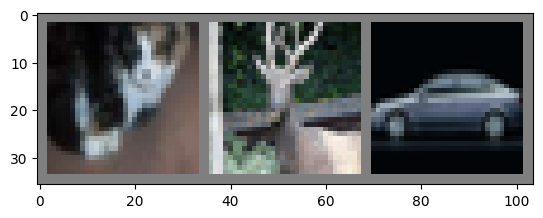

cat   deer  car  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:3]))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(3)))

Model Architecture


<img src="https://drive.google.com/uc?export=view&id=1xHEAPJ7iY6mtvLi5UwW4feobCqaY_rWm" width="800"/>

In [ ]:
import torch.nn as nn

class LeNet(nn.Module):
  def __init__(self, num_classes):
    super(LeNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84, num_classes)
    self.relu = nn.ReLU()
    self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.avgpool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.avgpool(x)
    x = self.conv3(x)
    x = self.relu(x)
    
    x = x.reshape(x.shape[0], -1)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    return x

Model Summary

In [ ]:
from torchsummary import summary

num_classes = 10
model = LeNet(num_classes).to(device)

x = torch.randn(64,3,32,32).to(device)
output = model(x)

print(model)
summary(model, (3,32,32))
print("output.shape : ",output.shape)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              ReLU-8        

Training Script

In [ ]:
def train(model, trainloader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total



In [ ]:
import torch.optim as optim
learning_rate = 0.1
num_epoch = 3

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

iter_per_epoch = len(trainloader)

best_epoch, best_acc = 0.0, 0
for epoch in range(1, num_epoch + 1):
    
    train(model, trainloader, criterion, optimizer, epoch)
    accuracy = test(model, testloader)

    if accuracy > best_acc:
        best_acc = accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model_cifar100.pth.tar')
    print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
            epoch, accuracy, best_epoch, best_acc))
    


epoch: 1  acc: 0.4013  best epoch: 1  best acc: 0.4013
epoch: 2  acc: 0.4736  best epoch: 2  best acc: 0.4736
epoch: 3  acc: 0.5134  best epoch: 3  best acc: 0.5134
